In [1]:
import json
import requests
import numpy
import cv2
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import copy
from torchvision import transforms
from matplotlib.colors import ListedColormap
import torchvision

In [2]:
# Load ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()
imgclasses = {i: labels[i] for i in range(len(labels))}


In [3]:
def toconv(layers):
    converted_layers = []
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            conv_layer = None
            if i == 0:
                input_channels, output_channels = 512, layer.weight.shape[0]
                kernel_size = 7
            else:
                input_channels, output_channels = layer.weight.shape[1], layer.weight.shape[0]
                kernel_size = 1
                
            conv_layer = nn.Conv2d(input_channels, output_channels, kernel_size)
            conv_layer.weight = nn.Parameter(layer.weight.reshape(output_channels, input_channels, kernel_size, kernel_size))
            conv_layer.bias = nn.Parameter(layer.bias)
            converted_layers.append(conv_layer)
        else:
            converted_layers.append(layer)
    return converted_layers

In [4]:
def heatmap(R,sx,sy):

    b = 10*((numpy.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(numpy.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx,sy))
    plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
    # plt.axis('off')
    plt.imshow(R,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    plt.show()


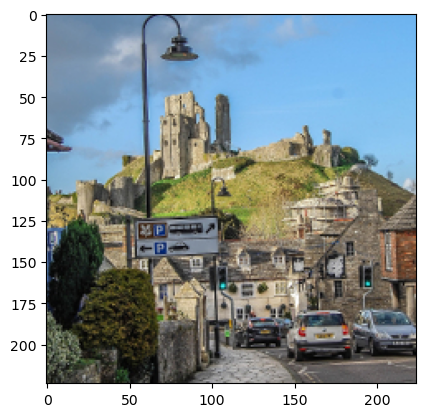

In [5]:
img_bgr = cv2.imread('data/castle.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = img_rgb / 255.0
img_s=mpimg.imread('data/castle.jpg')
imgplot = plt.imshow(img_s)
plt.show()

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensor = transform(img)  

X = img_tensor.unsqueeze(0)
X = X.float()

In [41]:
X.shape

torch.Size([1, 3, 224, 224])

In [7]:
model = torchvision.models.vgg19(pretrained=True)
model.eval()
layers = list(model._modules['features']) + toconv(list(model._modules['classifier']))

L = len(layers)

c:\ProgramData\miniconda3\envs\env_gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\env_gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
activations = [X]+[None]*L
for l in range(L): 
    activations[l+1] = layers[l].forward(activations[l])

In [11]:
scores = numpy.array(activations[-1].data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(imgclasses[i][:20],i,scores[i]))

              castle (483):  9.271
           monastery (663):  7.680
              church (497):  7.630
            bell-cot (442):  7.456
        analog clock (409):  7.092
        traffic sign (919):  6.888
                 alp (970):  6.786
       traffic light (920):  6.715
              palace (698):  6.369
          wall clock (892):  6.249


In [12]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==ind[0]).reshape([1,1000,1,1])))

R = [None] * L + [(activations[-1]*T).data]

In [13]:
def newlayer(layer,g):

    layer = copy.deepcopy(layer)
    try: 
        layer.weight = nn.Parameter(g(layer.weight))
    except AttributeError: 
        pass

    try: 
        layer.bias   = nn.Parameter(g(layer.bias))
    except AttributeError: 
        pass

    return layer


In [15]:
for l in range(1,L)[::-1]:
    
    activations[l] = (activations[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): 
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:      
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        if 17 <= l <= 30: 
            rho = lambda p: p
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       
            rho = lambda p: p
            incr = lambda z: z+1e-9

        z = incr(newlayer(layers[l],rho).forward(activations[l]))        # step 1
        s = (R[l+1]/z).data                                              # step 2
        (z*s).sum().backward(); c = activations[l].grad                  # step 3
        R[l] = (activations[l]*c).data                                   # step 4
    else:
        R[l] = R[l+1]


0 31


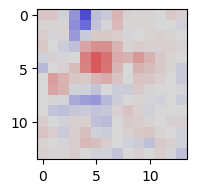

1 21


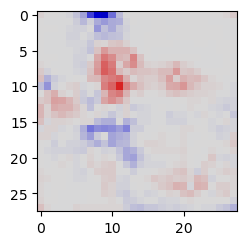

2 11


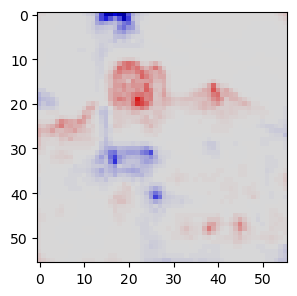

3 1


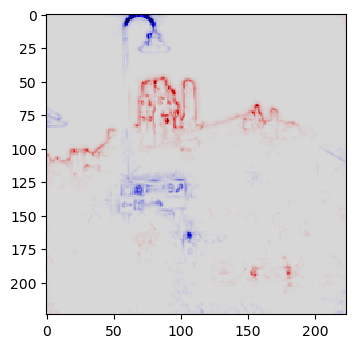

In [16]:
for i,l in enumerate([31,21,11,1]):
    print(i, l)
    heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [19]:
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

activations[0] = (activations[0].data).requires_grad_(True)

lb = (activations[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (activations[0].data*0+(1-mean)/std).requires_grad_(True)
z = layers[0].forward(activations[0]) + 1e-9                                     # step 1 (a)
z -= newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = activations[0].grad,lb.grad,hb.grad            # step 3
R[0] = (activations[0]*c+lb*cp+hb*cm).data                                       # step 4

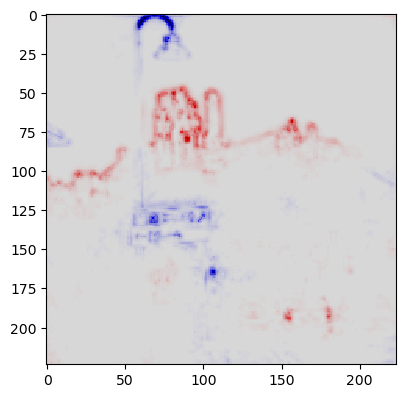

In [20]:
heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)